# Mutational Signatures to Gene Expression Regression Analysis

This notebook explores the relationship between mutational signatures and gene expression patterns across TCGA Pan-Cancer data.

## Overview
- Load and preprocess TCGA mutational signatures data
- Load and preprocess TCGA gene expression data
- Build regression models to predict gene expression from mutational signatures
- Evaluate model performance and biological significance

In [68]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import kaleido


# Set plotting style
sns.set_context('notebook')
%matplotlib inline

In [69]:
import os
sigs_dir_musical='/gpfs/data/courses/aio2025/yb2612/results/musical_matrices/final_H'
matrices_paths = [x for x in os.listdir(sigs_dir_musical) if x.endswith('.csv')]
# Split the filenames in that directory by _, keep the first part and prepend it to the name of each column in each respective matrix
matrices = [pd.read_csv(os.path.join(sigs_dir_musical, m), index_col=0) for m in matrices_paths]
prefixes = [m.split('_')[0] for m in matrices_paths]
for i, m in enumerate(matrices):
    m.index = [prefixes[i] + '-' + col for col in m.index]
# Merge the matrices, but take into account the different columns
merged_matrix_musical = pd.concat(matrices, axis=1)

In [70]:
# Load the gene expression data

expr_dir = '/gpfs/data/courses/aio2025/yb2612/data/c6_top1000'
expr_files = [x for x in os.listdir(expr_dir) if x.endswith('.csv')]
# Remove the file if it contains pangyn
expr_files = [x for x in expr_files if 'pangyn' not in x]
expr_matrices = [pd.read_csv(os.path.join(expr_dir, x), index_col=0) for x in expr_files]
expr_matrix = pd.concat(expr_matrices, axis=1)
prefixes = [x.split('_')[0] for x in expr_files]
for i, m in enumerate(expr_matrices):
    m.index = [prefixes[i] + '-' + col for col in m.index]
# Rearrange the column order for all the matrices in expr_matrices
# First get the intersection of the columns of all the matrices. There's 4 of them
common_columns = np.intersect1d(expr_matrices[0].columns, expr_matrices[1].columns)
common_columns = np.intersect1d(common_columns, expr_matrices[2].columns)
common_columns = np.intersect1d(common_columns, expr_matrices[3].columns)
# Then rearrange the columns of all the matrices to be in the same order
for i, m in enumerate(expr_matrices):
    expr_matrices[i] = m[common_columns]
# Merge the matrices across rows, but take into account the different columns
merged_matrix_expr = pd.concat(expr_matrices, axis=0)
# Select the samples in the expression matrix whose rownames end with a -01
merged_matrix_expr = merged_matrix_expr[merged_matrix_expr.index.str.endswith('-01')]
# Remove that suffix from the index
merged_matrix_expr.index = merged_matrix_expr.index.str.rstrip('-01')



In [71]:
merged_matrix_expr.head()

,AADAC,ABCA12,ABCA6,ABCA8,ABCC8,ABI3BP,ABO,ACADL,ACOX2,ACSS3,...,ZFHX4,ZFP57,ZFR2,ZIC1,ZIC2,ZIC4,ZMYND10,ZNF208,ZNF486,ZNF750
cesc-TCGA-EA-A3HT,-0.718326,3.044115,0.697362,-2.215246,-3.761244,-0.683764,6.136247,-1.828385,-1.587251,-1.291025,...,2.02848,-2.195334,5.226959,-3.183742,4.899883,-1.781519,-3.297346,-1.13787,-2.24056,4.467438
cesc-TCGA-FU-A3HZ,-1.672426,-2.269785,-3.069238,-1.949146,0.525056,-4.518464,-2.879753,-2.729585,-1.997751,4.676375,...,-1.42592,-0.261134,-2.519341,4.461158,6.160883,2.990281,-2.938346,-2.29967,-3.68176,1.588238
cesc-TCGA-FU-A3TQ,-0.286226,5.515515,-1.654338,-2.796646,-3.761244,-0.585964,3.564947,0.053015,-2.662951,-3.777425,...,-1.92902,-0.437334,6.376159,2.983158,3.557783,-0.221919,-1.264946,-2.09587,-3.35076,4.896038
cesc-TCGA-DS-A0VK,0.991774,5.130615,-1.099038,-2.682046,-3.761244,-0.821264,3.452347,-2.729585,-4.235251,-2.949225,...,-3.33832,-1.273534,6.662059,-3.183742,4.819283,-2.148019,-3.494446,-2.79817,-4.09116,2.387538
cesc-TCGA-UC-A7PG,-1.751126,4.317315,-1.610638,-2.342946,-3.761244,-0.532964,1.248747,1.567015,-2.461451,-4.074725,...,0.95228,-1.998034,2.941459,-3.183742,4.744883,-2.148019,-4.493946,-1.81197,-2.84776,5.839938


In [72]:
merged_matrix_expr.shape

(1880, 1000)

In [73]:
# Load Adam's sample x signature matrix
sigassigner_dir = '/gpfs/data/courses/aio2025/adw9882/Analysis/output/'
# Get all subfolders there
sigassigner_dirs = [x for x in os.listdir(sigassigner_dir) if os.path.isdir(os.path.join(sigassigner_dir, x))]
# Remove logs if it is there
sigassigner_dirs = [x for x in sigassigner_dirs if 'logs' not in x]
prefixes = [x.split('_')[-1] for x in sigassigner_dirs]
# Append 'Assignment_Solution/Activities/Assignment_Solution_Activities.txt' to each of them
sigassigner_files = [os.path.join(sigassigner_dir, d, 'Assignment_Solution', 'Activities', 'Assignment_Solution_Activities.txt') for d in sigassigner_dirs]
# Load the files
sigassigner_matrices = [pd.read_table(f, index_col=0, delimiter='\t') for f in sigassigner_files]
for i, m in enumerate(sigassigner_matrices):
    m.index = [prefixes[i] + '-' + col for col in m.index]
# Merge the matrices, but take into account the different columns
merged_matrix_sigassigner = pd.concat(sigassigner_matrices, axis=1)



In [74]:
# Intersect the matrices to get common rows (samples) and expression matrix. 3 matrices

common_samples = np.unique(np.array(list(set(merged_matrix_musical.index) & set(merged_matrix_sigassigner.index) & set(merged_matrix_expr.index))))







In [75]:
print(len(common_samples))

1602


In [76]:
# Subset each matrix
merged_matrix_musical = merged_matrix_musical.loc[common_samples]
merged_matrix_sigassigner = merged_matrix_sigassigner.loc[common_samples]
merged_matrix_expr = merged_matrix_expr.loc[common_samples]
# Set NaN to 0
merged_matrix_musical = merged_matrix_musical.fillna(0)
merged_matrix_sigassigner = merged_matrix_sigassigner.fillna(0)
# Scale the data
merged_matrix_musical = merged_matrix_musical.div(merged_matrix_musical.sum(axis=1), axis=0)
merged_matrix_sigassigner = merged_matrix_sigassigner.div(merged_matrix_sigassigner.sum(axis=1), axis=0)

merged_matrix_musical.columns = ['msc-' + col for col in merged_matrix_musical.columns]
merged_matrix_sigassigner.columns = ['sa-' + col for col in merged_matrix_sigassigner.columns]
# Prefix each column of musical with msc and sigassigner with sa so that it is msc-sbs1, msc-sbs2, etc.

# Concatenate them on the y axis
merged_matrix_signatures = pd.concat([merged_matrix_musical, merged_matrix_sigassigner], axis=1)

# NaN to 0
merged_matrix_signatures = merged_matrix_signatures.fillna(0)
merged_matrix_expr = merged_matrix_expr.fillna(0)

In [79]:
# Filter signatures that have low variance across samples (rows)
merged_matrix_signatures = merged_matrix_signatures.loc[:, merged_matrix_signatures.var() > 1]
print(merged_matrix_signatures.shape)

(1602, 16)


In [80]:
# Filter genes that have low variance across samples (rows)
merged_matrix_expr = merged_matrix_expr.loc[:, merged_matrix_expr.var() > 1]
print(merged_matrix_expr.shape)

(1602, 1000)


<Axes: ylabel='Count'>

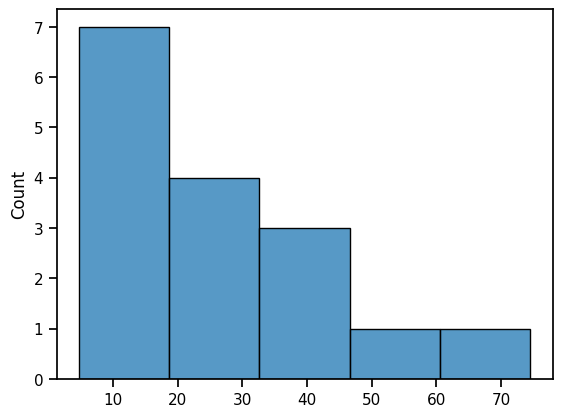

In [81]:
sns.histplot(merged_matrix_signatures.max(axis=0))

In [82]:
# Fixed SHAP Analysis Function
def advanced_feature_importance(model, test_loader, signature_names, gene_names, 
                                     num_background_samples=50, num_target_genes=5):
    """
    Perform advanced feature importance analysis with robust error handling.
    
    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test data
        signature_names: List of mutational signature names
        gene_names: List of gene names
        num_background_samples: Number of samples to use for background distribution
        num_target_genes: Number of top genes to analyze
    """
    model.eval()
    
    # Get a batch of data for analysis
    signatures_batch = None
    for batch in test_loader:
        signatures_batch, expressions_batch = batch
        if len(signatures_batch) >= 20:  # Get a reasonably sized batch
            break
    
    if signatures_batch is None:
        print("Could not get batch data from test_loader")
        return None
        
    signatures_batch = signatures_batch.to(device)
    expressions_batch = expressions_batch.to(device)
    
    # Convert to numpy for easier handling
    signatures_numpy = signatures_batch.cpu().numpy()
    expressions_numpy = expressions_batch.cpu().numpy()
    
    print(f"Running advanced feature importance analysis on {num_target_genes} top genes...")
    
    # Get R² scores for each gene to find the most predictable genes
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for signatures, expressions in test_loader:
            signatures, expressions = signatures.to(device), expressions.to(device)
            outputs = model(signatures)
            
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(expressions.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    targets = np.vstack(all_targets)
    
    r2_scores = []
    for i in range(targets.shape[1]):
        r2 = np.corrcoef(predictions[:, i], targets[:, i])[0, 1] ** 2
        r2_scores.append(r2)
    
    # Select top genes by R² for detailed analysis
    top_genes_idx = np.argsort(r2_scores)[-num_target_genes:][::-1]
    top_gene_names = [gene_names[idx] for idx in top_genes_idx]
    
    print(f"Top {num_target_genes} genes selected for analysis: {', '.join(top_gene_names)}")
    
    # Create a directory for feature importance visualizations
    os.makedirs("feature_importance", exist_ok=True)
    
    # --------------------------------
    # 1. SHAP Analysis (Fixed Version)
    # --------------------------------
    print("Running SHAP analysis...")
    
    try:
        # PyTorch model wrapper for SHAP
        class TorchModelWrapper:
            def __init__(self, model, target_gene_idx):
                self.model = model
                self.target_gene_idx = target_gene_idx
                
            def __call__(self, X):
                if isinstance(X, np.ndarray):
                    X = torch.tensor(X, dtype=torch.float32).to(device)
                with torch.no_grad():
                    output = self.model(X)[:, self.target_gene_idx]
                return output.cpu().numpy()
        
        # Get background data for SHAP
        background_data = []
        background_counter = 0
        
        for signatures, _ in test_loader:
            if background_counter >= num_background_samples:
                break
            batch_size = len(signatures)
            needed = min(batch_size, num_background_samples - background_counter)
            background_data.append(signatures.numpy()[:needed])
            background_counter += needed
            
        background = np.vstack(background_data)
        print(f"Using background data of shape: {background.shape}")
        
        # Run SHAP for each top gene
        for i, gene_idx in enumerate(top_genes_idx):
            gene_name = gene_names[gene_idx]
            print(f"SHAP analysis for gene {gene_name} (R²={r2_scores[gene_idx]:.3f})...")
            
            # Create a wrapper model for this gene
            wrapped_model = TorchModelWrapper(model, gene_idx)
            
            # Use KernelExplainer instead of DeepExplainer for more robustness
            explainer = shap.KernelExplainer(wrapped_model, background[:50])
            
            # Get SHAP values for a subset of samples
            sample_data = signatures_numpy[:20]
            shap_values = explainer.shap_values(sample_data)
            
            # Handle different return types
            if isinstance(shap_values, list):
                if len(shap_values) > 0:
                    shap_values = shap_values[0]
            
            # Plot SHAP summary
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, sample_data, feature_names=signature_names, 
                             show=False, plot_size=(12, 8))
            plt.title(f"SHAP Summary for Gene: {gene_name}")
            plt.tight_layout()
            plt.savefig(f"feature_importance/shap_summary_{gene_name}.png", dpi=300, bbox_inches='tight')
            plt.close()
            
            # Save SHAP values to CSV
            shap_df = pd.DataFrame(shap_values, columns=signature_names)
            shap_df['gene_name'] = gene_name
            shap_df.to_csv(f"feature_importance/shap_values_{gene_name}.csv", index=False)
            
            # Plot individual SHAP dependency plots for top 5 features
            mean_abs_shap = np.abs(shap_values).mean(axis=0)
            top_features_idx = np.argsort(mean_abs_shap)[-5:]
            
            for feat_idx in top_features_idx:
                plt.figure(figsize=(8, 6))
                shap.dependence_plot(feat_idx, shap_values, sample_data, 
                                    feature_names=signature_names, show=False)
                plt.title(f"SHAP Dependence Plot: {gene_name} vs {signature_names[feat_idx]}")
                plt.tight_layout()
                plt.savefig(f"feature_importance/shap_dependence_{gene_name}_{signature_names[feat_idx]}.png", 
                           dpi=300, bbox_inches='tight')
                plt.close()
        
    except Exception as e:
        print(f"Error in SHAP analysis: {e}")
        import traceback
        traceback.print_exc()
    
    # --------------------------------
    # 2. Integrated Gradients Analysis
    # --------------------------------
    print("Running Integrated Gradients analysis...")
    
    try:
        # Create a PyTorch model wrapper for IG
        class IGModelWrapper(nn.Module):
            def __init__(self, base_model, target_gene_idx):
                super().__init__()
                self.base_model = base_model
                self.target_gene_idx = target_gene_idx
                
            def forward(self, x):
                return self.base_model(x)[:, self.target_gene_idx]
        
        # Run Integrated Gradients for each top gene
        for i, gene_idx in enumerate(top_genes_idx):
            gene_name = gene_names[gene_idx]
            print(f"Integrated Gradients analysis for gene {gene_name}...")
            
            # Create a wrapper model for this gene
            wrapped_model = IGModelWrapper(model, gene_idx).to(device)
            
            # Create the IG explainer
            ig = IntegratedGradients(wrapped_model)
            
            # Calculate attributions for a subset of samples
            num_samples = min(20, signatures_batch.shape[0])
            attributions, delta = ig.attribute(signatures_batch[:num_samples], 
                                              return_convergence_delta=True)
            
            # Convert to numpy
            attributions = attributions.cpu().detach().numpy()
            
            # Create visualization
            plt.figure(figsize=(15, 10))
            
            # Plot heatmap of attributions
            ax = plt.subplot(111)
            im = ax.imshow(attributions, cmap='coolwarm', aspect='auto')
            
            # Add colorbar
            plt.colorbar(im, ax=ax, label='Attribution Score')
            
            # Set labels
            ax.set_xlabel('Mutational Signature')
            ax.set_ylabel('Sample')
            ax.set_title(f'Integrated Gradients Attributions for {gene_name}')
            
            # Set x-axis tick labels to feature names (only show a subset for clarity)
            tick_indices = np.linspace(0, len(signature_names)-1, min(20, len(signature_names))).astype(int)
            ax.set_xticks(tick_indices)
            ax.set_xticklabels([signature_names[i] for i in tick_indices], rotation=90)
            
            plt.tight_layout()
            plt.savefig(f"feature_importance/ig_heatmap_{gene_name}.png", dpi=300, bbox_inches='tight')
            plt.close()
            
            # Save mean absolute attributions
            mean_abs_attr = np.abs(attributions).mean(axis=0)
            attr_df = pd.DataFrame({
                'Signature': signature_names,
                'Mean_Abs_Attribution': mean_abs_attr
            })
            attr_df = attr_df.sort_values('Mean_Abs_Attribution', ascending=False)
            attr_df.to_csv(f"feature_importance/ig_attributions_{gene_name}.csv", index=False)
            
            # Plot the top 10 signatures by attribution
            plt.figure(figsize=(12, 6))
            top_attrs = attr_df.head(10)
            sns.barplot(x='Mean_Abs_Attribution', y='Signature', data=top_attrs)
            plt.title(f'Top 10 Signatures by IG Attribution for {gene_name}')
            plt.tight_layout()
            plt.savefig(f"feature_importance/ig_top10_{gene_name}.png", dpi=300, bbox_inches='tight')
            plt.close()
    
    except Exception as e:
        print(f"Error in Integrated Gradients analysis: {e}")
        import traceback
        traceback.print_exc()
    
    # --------------------------------
    # 3. Feature Permutation Analysis
    # --------------------------------
    print("Running Feature Permutation analysis...")
    
    try:
        # Run for each top gene
        for i, gene_idx in enumerate(top_genes_idx):
            gene_name = gene_names[gene_idx]
            print(f"Feature Permutation analysis for gene {gene_name}...")
            
            # Create a wrapper model for this gene
            wrapped_model = IGModelWrapper(model, gene_idx).to(device)
            
            # Create the permutation explainer
            perm = FeaturePermutation(wrapped_model)
            
            # Calculate attributions for a subset of samples
            num_samples = min(20, signatures_batch.shape[0])
            perm_attr = perm.attribute(signatures_batch[:num_samples])
            
            # Convert to numpy
            perm_attr = perm_attr.cpu().detach().numpy()
            perm_attr_mean = np.mean(perm_attr, axis=0)
            
            # Create a DataFrame
            perm_df = pd.DataFrame({
                'Signature': signature_names,
                'Permutation_Importance': perm_attr_mean
            })
            perm_df = perm_df.sort_values('Permutation_Importance', ascending=False)
            perm_df.to_csv(f"feature_importance/permutation_importance_{gene_name}.csv", index=False)
            
            # Plot
            plt.figure(figsize=(12, 6))
            top_perms = perm_df.head(10)
            sns.barplot(x='Permutation_Importance', y='Signature', data=top_perms)
            plt.title(f'Top 10 Signatures by Permutation Importance for {gene_name}')
            plt.tight_layout()
            plt.savefig(f"feature_importance/permutation_top10_{gene_name}.png", dpi=300, bbox_inches='tight')
            plt.close()
    
    except Exception as e:
        print(f"Error in Feature Permutation analysis: {e}")
        import traceback
        traceback.print_exc()
    
    print("Advanced feature importance analysis complete. Results saved in 'feature_importance' directory.")
    
    return {
        "top_genes": top_gene_names,
        "top_genes_idx": top_genes_idx,
        "r2_scores": [r2_scores[idx] for idx in top_genes_idx]
    }

In [83]:
np.min(np.sum(merged_matrix_signatures == 0,axis=0))

np.int64(620)

<Axes: ylabel='Count'>

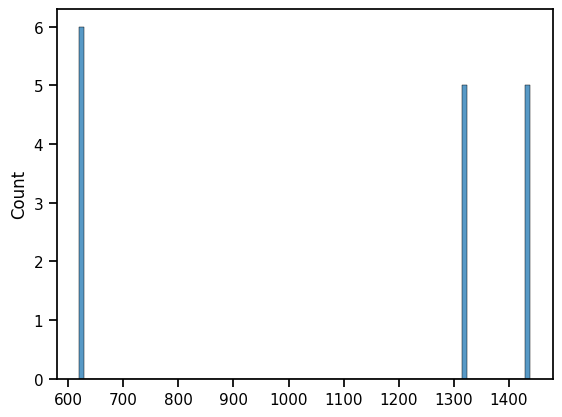

In [85]:
sns.histplot(np.sum(merged_matrix_signatures == 0,axis=0),bins=100)

In [96]:
merged_matrix_signatures.columns[np.sum(merged_matrix_signatures == 0,axis=0) < 1000]

Index(['msc-SBS17a', 'msc-SBS3', 'msc-SBS51', 'msc-SBS54', 'msc-SBS60',
       'msc-SBS8'],
      dtype='object')

In [94]:
np.unique([x.split('-')[0] for x in merged_matrix_signatures.index], return_counts=True)

(array(['brca', 'cesc', 'ov', 'ucec'], dtype='<U4'),
 array([982, 285, 171, 164]))

In [95]:
np.unique([x.split('-')[0] for x in merged_matrix_signatures.index[np.sum(merged_matrix_signatures == 0,axis=1) > 14]],
          return_counts=True)

(array(['ucec'], dtype='<U4'), array([164]))

In [66]:
keep_sigs = np.sum(merged_matrix_signatures == 0,axis=0)
merged_matrix_signatures = merged_matrix_signatures.loc[:,keep_sigs < 700]

In [67]:
merged_matrix_signatures.shape

(1602, 16)

[I 2025-05-07 22:25:22,876] A new study created in memory with name: mutational_signatures_study


Signature matrix shape: (1602, 16)
Expression matrix shape: (1602, 185)
Using device: cuda


/tmp/ipykernel_3209917/855217459.py:170: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_layers.append(trial.suggest_int(f'hidden_dim_{i}', 32, 256, 32))
/gpfs/scratch/nk4167/miniconda/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-07 22:25:23,289] Trial 0 finished with value: 0.7791642546653748 and parameters: {'n_layers': 1, 'hidden_dim_0': 96, 'dropout_rate': 0.2, 'weight_decay': 0.0002926419733010241, 'use_batch_norm': True, 'batch_size': 256, 'learning_rate': 0.005149361628102751, 'clip_value': 0.2514248163534243}. Best is trial 0 with value: 0.7791642546653748.


Early stopping triggered after 24 epochs


[I 2025-05-07 22:25:30,383] Trial 1 finished with value: 0.762660127133131 and parameters: {'n_layers': 4, 'hidden_dim_0': 224, 'hidden_dim_1': 160, 'hidden_dim_2': 256, 'hidden_dim_3': 32, 'dropout_rate': 0.4, 'weight_decay': 3.014686127816868e-06, 'use_batch_norm': True, 'batch_size': 64, 'learning_rate': 1.6160556532991713e-05, 'clip_value': 1.7081205549469909}. Best is trial 1 with value: 0.762660127133131.
[I 2025-05-07 22:25:31,791] Trial 2 finished with value: 0.7286565070971847 and parameters: {'n_layers': 3, 'hidden_dim_0': 256, 'hidden_dim_1': 64, 'hidden_dim_2': 160, 'dropout_rate': 0.1, 'weight_decay': 3.3744573446325006e-06, 'use_batch_norm': True, 'batch_size': 64, 'learning_rate': 0.0011799646827592195, 'clip_value': 0.24106995254480368}. Best is trial 2 with value: 0.7286565070971847.


Early stopping triggered after 24 epochs


[I 2025-05-07 22:25:41,795] Trial 3 finished with value: 0.7581780583908161 and parameters: {'n_layers': 3, 'hidden_dim_0': 160, 'hidden_dim_1': 160, 'hidden_dim_2': 128, 'dropout_rate': 0.5, 'weight_decay': 3.206594573553848e-05, 'use_batch_norm': True, 'batch_size': 16, 'learning_rate': 0.00024269384389689257, 'clip_value': 0.8492578432479292}. Best is trial 2 with value: 0.7286565070971847.


Early stopping triggered after 48 epochs


[I 2025-05-07 22:25:45,620] Trial 4 finished with value: 0.7770110721389453 and parameters: {'n_layers': 1, 'hidden_dim_0': 160, 'dropout_rate': 0.30000000000000004, 'weight_decay': 1.0715827826364317e-05, 'use_batch_norm': True, 'batch_size': 16, 'learning_rate': 0.00036498844361544875, 'clip_value': 1.717112201105217}. Best is trial 2 with value: 0.7286565070971847.


Early stopping triggered after 26 epochs


[I 2025-05-07 22:25:48,931] Trial 5 finished with value: 0.7185661473777145 and parameters: {'n_layers': 4, 'hidden_dim_0': 224, 'hidden_dim_1': 32, 'hidden_dim_2': 32, 'hidden_dim_3': 256, 'dropout_rate': 0.2, 'weight_decay': 0.0005618125352045067, 'use_batch_norm': True, 'batch_size': 32, 'learning_rate': 0.0031741785062179314, 'clip_value': 1.6718853276544876}. Best is trial 5 with value: 0.7185661473777145.
[I 2025-05-07 22:25:49,089] Trial 6 pruned. 


Early stopping triggered after 26 epochs


[I 2025-05-07 22:25:49,646] Trial 7 finished with value: 0.7387726530432701 and parameters: {'n_layers': 1, 'hidden_dim_0': 64, 'dropout_rate': 0.30000000000000004, 'weight_decay': 1.1181035886363537e-05, 'use_batch_norm': False, 'batch_size': 128, 'learning_rate': 0.007474329262394031, 'clip_value': 0.37109821286941713}. Best is trial 5 with value: 0.7185661473777145.


Early stopping triggered after 23 epochs


[I 2025-05-07 22:25:51,058] Trial 8 pruned. 
[I 2025-05-07 22:25:52,502] Trial 9 finished with value: 0.7451031235978007 and parameters: {'n_layers': 3, 'hidden_dim_0': 192, 'hidden_dim_1': 256, 'hidden_dim_2': 160, 'dropout_rate': 0.1, 'weight_decay': 1.1008280439890934e-06, 'use_batch_norm': True, 'batch_size': 64, 'learning_rate': 0.0009073399892300023, 'clip_value': 1.9035934937060834}. Best is trial 5 with value: 0.7185661473777145.


Early stopping triggered after 22 epochs
Study statistics: 
  Number of finished trials:  10
  Best trial:
    Value:  0.7185661473777145
    Params: 
      n_layers: 4
      hidden_dim_0: 224
      hidden_dim_1: 32
      hidden_dim_2: 32
      hidden_dim_3: 256
      dropout_rate: 0.2
      weight_decay: 0.0005618125352045067
      use_batch_norm: True
      batch_size: 32
      learning_rate: 0.0031741785062179314
      clip_value: 1.6718853276544876


/gpfs/scratch/nk4167/miniconda/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training final model with best hyperparameters...
Epoch 10/100:
Training Loss: 0.9450
Validation Loss: 0.7392
Epoch 20/100:
Training Loss: 0.8390
Validation Loss: 0.7195
Epoch 30/100:
Training Loss: 0.7423
Validation Loss: 0.9000
Epoch 40/100:
Training Loss: 0.6746
Validation Loss: 0.7392
Early stopping triggered after 40 epochs
Training completed in 5.07 seconds (0.08 minutes)


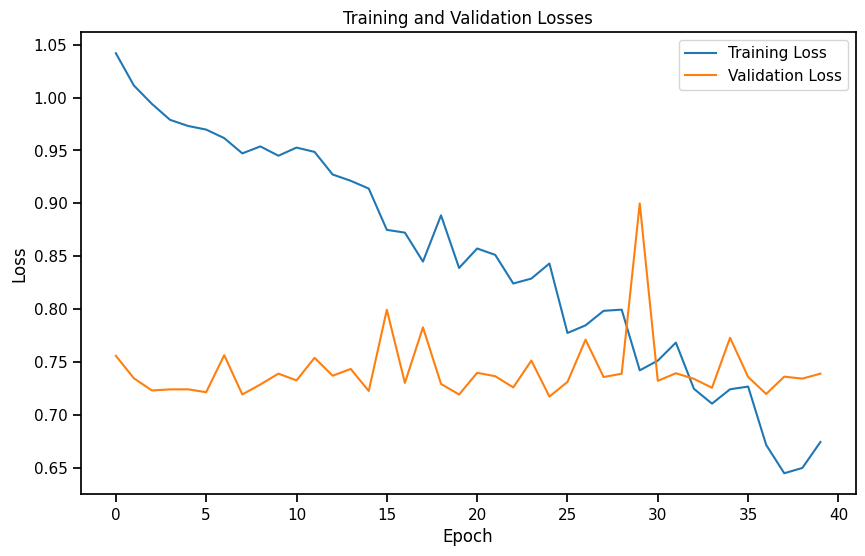

Test Loss: 0.4486


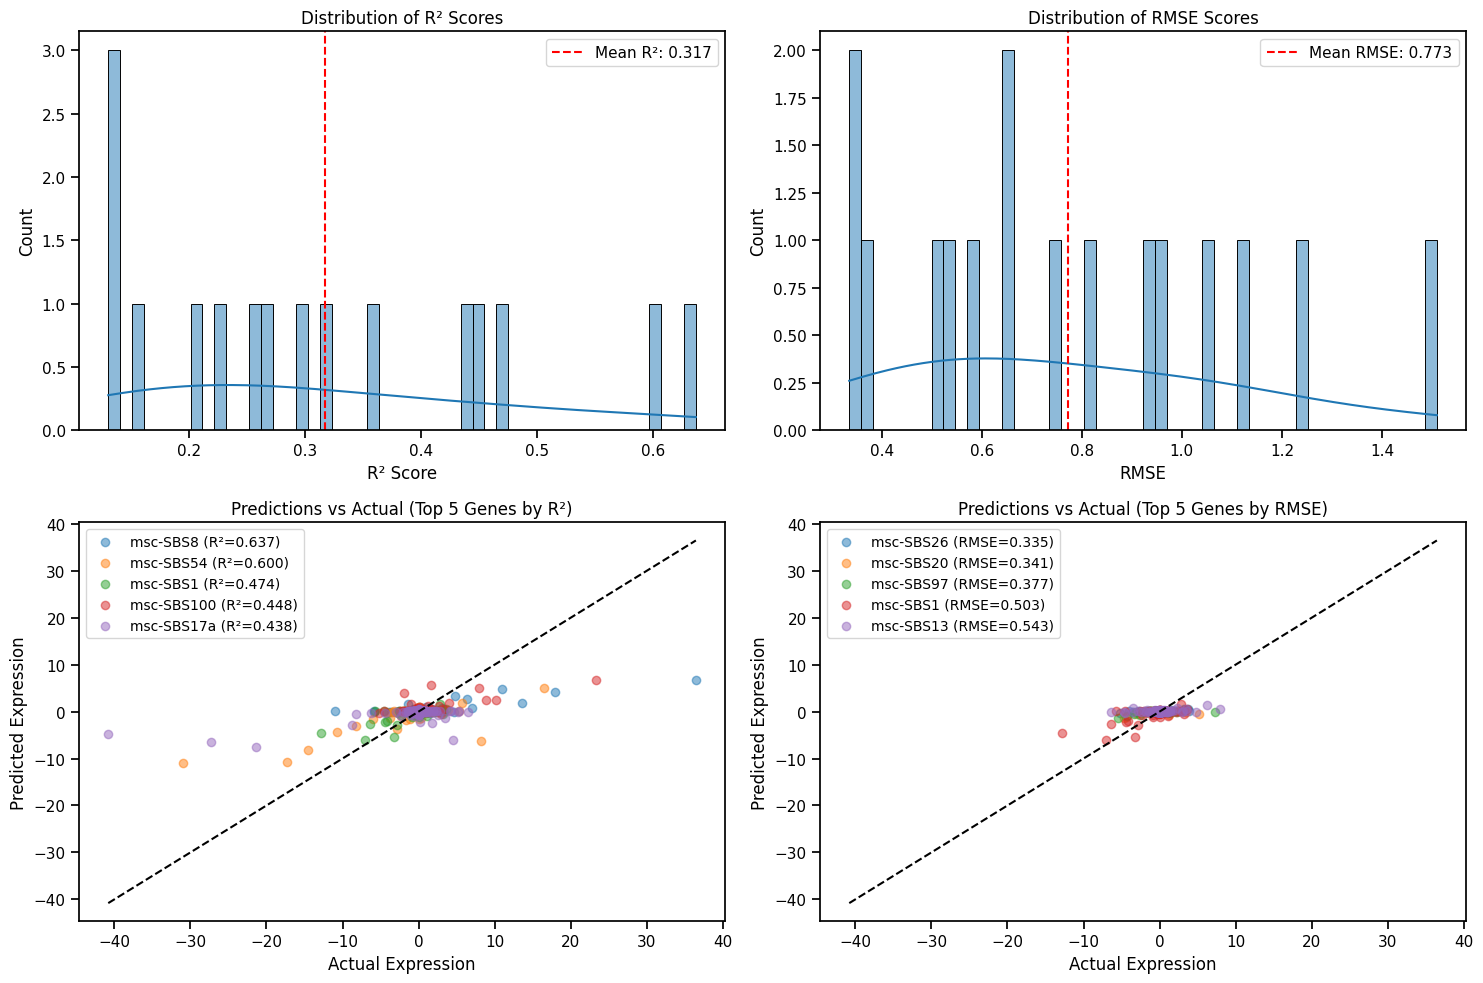


R² Score Statistics:
Mean R² score: 0.317
Median R² score: 0.285
Max R² score: 0.637
Min R² score: 0.130
Std Dev R² score: 0.158

RMSE Statistics:
Mean RMSE: 0.773
Median RMSE: 0.701
Min RMSE: 0.335
Max RMSE: 1.510
Std Dev RMSE: 0.332

Top 10 genes by R² score:
1. msc-SBS8: R²=0.637, RMSE=1.246
2. msc-SBS54: R²=0.600, RMSE=1.048
3. msc-SBS1: R²=0.474, RMSE=0.503
4. msc-SBS100: R²=0.448, RMSE=0.754
5. msc-SBS17a: R²=0.438, RMSE=1.510
6. msc-SBS3: R²=0.359, RMSE=0.949
7. msc-SBS51: R²=0.315, RMSE=0.817
8. msc-SBS5: R²=0.299, RMSE=0.944
9. msc-SBS97: R²=0.271, RMSE=0.377
10. msc-SBS96: R²=0.255, RMSE=0.572

Bottom 10 genes by R² score:
1. msc-SBS20: R²=0.130, RMSE=0.341
2. msc-SBS26: R²=0.131, RMSE=0.335
3. msc-SBS13: R²=0.133, RMSE=0.543
4. msc-SBS98: R²=0.151, RMSE=0.648
5. msc-SBS2: R²=0.209, RMSE=0.647
6. msc-SBS60: R²=0.223, RMSE=1.130
7. msc-SBS96: R²=0.255, RMSE=0.572
8. msc-SBS97: R²=0.271, RMSE=0.377
9. msc-SBS5: R²=0.299, RMSE=0.944
10. msc-SBS51: R²=0.315, RMSE=0.817

Detailed

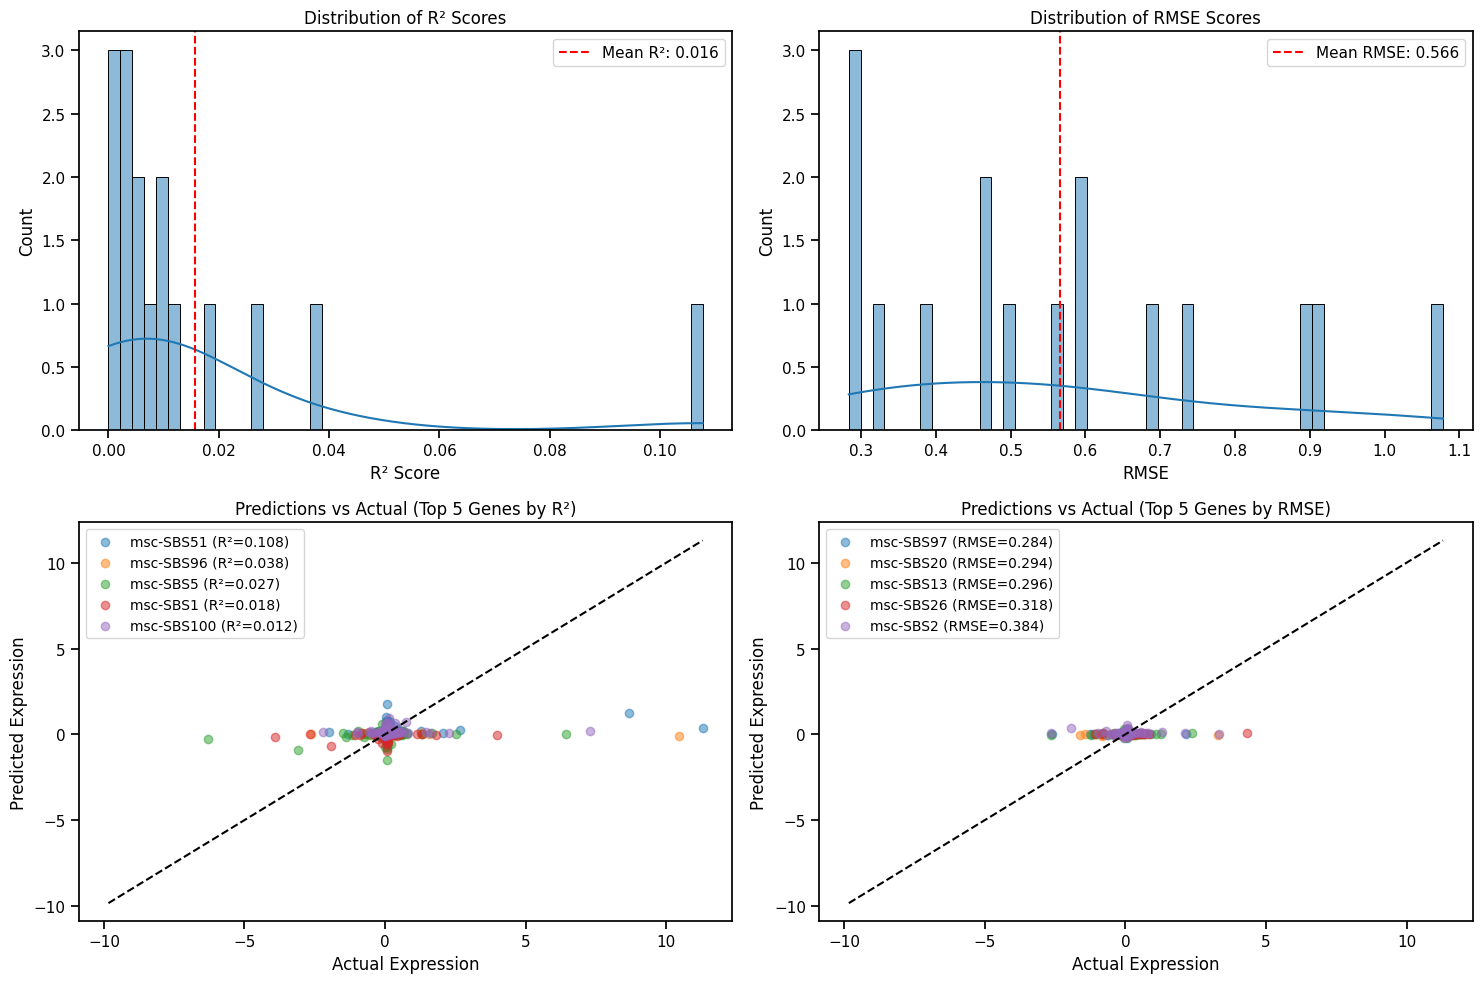


R² Score Statistics:
Mean R² score: 0.016
Median R² score: 0.007
Max R² score: 0.108
Min R² score: 0.000
Std Dev R² score: 0.026

RMSE Statistics:
Mean RMSE: 0.566
Median RMSE: 0.523
Min RMSE: 0.284
Max RMSE: 1.078
Std Dev RMSE: 0.235

Top 10 genes by R² score:
1. msc-SBS51: R²=0.108, RMSE=0.917
2. msc-SBS96: R²=0.038, RMSE=0.732
3. msc-SBS5: R²=0.027, RMSE=0.687
4. msc-SBS1: R²=0.018, RMSE=0.473
5. msc-SBS100: R²=0.012, RMSE=0.554
6. msc-SBS60: R²=0.010, RMSE=1.078
7. msc-SBS13: R²=0.009, RMSE=0.296
8. msc-SBS17a: R²=0.008, RMSE=0.594
9. msc-SBS3: R²=0.005, RMSE=0.590
10. msc-SBS98: R²=0.005, RMSE=0.463

Bottom 10 genes by R² score:
1. msc-SBS20: R²=0.000, RMSE=0.294
2. msc-SBS97: R²=0.000, RMSE=0.284
3. msc-SBS8: R²=0.001, RMSE=0.491
4. msc-SBS26: R²=0.003, RMSE=0.318
5. msc-SBS2: R²=0.003, RMSE=0.384
6. msc-SBS54: R²=0.004, RMSE=0.900
7. msc-SBS98: R²=0.005, RMSE=0.463
8. msc-SBS3: R²=0.005, RMSE=0.590
9. msc-SBS17a: R²=0.008, RMSE=0.594
10. msc-SBS13: R²=0.009, RMSE=0.296

Detaile

ValueError: All arrays must be of the same length

In [63]:
# Mutational Signatures to Gene Expression Regression Analysis with Optuna Tuning
#
# This notebook explores the relationship between mutational signatures and gene expression patterns
# across TCGA Pan-Cancer data, using Optuna for hyperparameter optimization.

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import time
import joblib
import os
import shap
from captum.attr import IntegratedGradients, Occlusion, FeaturePermutation
from captum.attr import visualization as viz

# Set plotting style
sns.set_context('notebook')
%matplotlib inline

# If you need CUDA determinism, uncomment these lines
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

# Fix random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Data loading and preprocessing - assuming you have the preprocessed data loaded
# Print dimensions of our data
print("Signature matrix shape:", merged_matrix_signatures.shape)
print("Expression matrix shape:", merged_matrix_expr.shape)

# Normalize the input data
scaler = StandardScaler()
X_train, X_temp, y_train, y_temp = train_test_split(
    merged_matrix_expr,
    merged_matrix_signatures,
    test_size=0.3,
    random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp,
    test_size=0.5,
    random_state=SEED
)

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
Y_train_scaled = scaler.fit_transform(y_train)
Y_val_scaled = scaler.transform(y_val)
Y_test_scaled = scaler.transform(y_test)

# Save the gene names for later
gene_names = y_test.columns.tolist()

# Custom Dataset class
class MutSigDataset(torch.utils.data.Dataset):
    def __init__(self, signatures, expressions):
        self.signatures = torch.FloatTensor(signatures)
        self.expressions = torch.FloatTensor(expressions.values)
        
    def __len__(self):
        return len(self.signatures)
    
    def __getitem__(self, idx):
        return self.signatures[idx], self.expressions[idx]

# Create datasets
train_dataset = MutSigDataset(X_train_scaled, y_train)
val_dataset = MutSigDataset(X_val_scaled, y_val)
test_dataset = MutSigDataset(X_test_scaled, y_test)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model definition with configurable architecture
class MutSigGeneExpressionNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate, use_batch_norm=False):
        super().__init__()
        
        # Create a dynamically sized network based on the hidden_layers parameter
        layers = []
        prev_dim = input_dim
        
        for dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, dim))
            
            # Add normalization layer
            if use_batch_norm:
                # Disable track_running_stats to prevent BatchNorm errors with batch_size=1
                layers.append(nn.BatchNorm1d(dim, track_running_stats=False))
            else:
                layers.append(nn.LayerNorm(dim))
                
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = dim
        
        self.encoder = nn.Sequential(*layers)
        
        # Output layer for gene expression prediction
        self.output_layer = nn.Linear(prev_dim, y_train.shape[1])
        
    def forward(self, x):
        shared_features = self.encoder(x)
        return self.output_layer(shared_features)

# Training function with gradient clipping
def train_epoch(model, train_loader, criterion, optimizer, device, clip_value=1.0):
    model.train()
    total_loss = 0
    for signatures, expressions in train_loader:
        signatures, expressions = signatures.to(device), expressions.to(device)
        
        optimizer.zero_grad()
        outputs = model(signatures)
        loss = criterion(outputs, expressions)
        loss.backward()
        
        # Gradient clipping
        if clip_value > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for signatures, expressions in val_loader:
            signatures, expressions = signatures.to(device), expressions.to(device)
            outputs = model(signatures)
            loss = criterion(outputs, expressions)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

# Define the objective function for Optuna
def objective(trial):
    # Sample hyperparameters
    # Network architecture
    n_layers = trial.suggest_int('n_layers', 1, 4)
    hidden_layers = []
    for i in range(n_layers):
        hidden_layers.append(trial.suggest_int(f'hidden_dim_{i}', 32, 256, 32))
    
    # Regularization
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5,step=0.1)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    
    # Training parameters
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    clip_value = trial.suggest_float('clip_value', 0.0, 2.0)
    
    # Create data loaders with the selected batch size
    # Ensure minimum batch size of 2 for BatchNorm to work
    if use_batch_norm:
        min_batch_size = max(2, batch_size)
    else:
        min_batch_size = batch_size
        
    train_loader = DataLoader(train_dataset, batch_size=min_batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=min_batch_size)
    
    # Initialize model
    model = MutSigGeneExpressionNet(
        input_dim=X_train_scaled.shape[1],
        hidden_layers=hidden_layers,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    ).to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5, verbose=False
    )
    
    # Training loop with early stopping
    num_epochs = 100
    patience = 20
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, clip_value)
        val_loss = validate(model, val_loader, criterion, device)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Report intermediate metric
        trial.report(val_loss, epoch)
        
        # Handle pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model weights for this trial
            torch.save(model.state_dict(), f'trial_{trial.number}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    return best_val_loss

# Function to run Optuna study
def run_optuna_study(n_trials=100, study_name="mutational_signatures_study"):
    # Create or load a study
    study = optuna.create_study(
        study_name=study_name,
        direction="minimize",
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )
    
    # Run optimization
    study.optimize(objective, n_trials=n_trials)
    
    # Print statistics
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Best trial:")
    trial = study.best_trial
    print("    Value: ", trial.value)
    print("    Params: ")
    for key, value in trial.params.items():
        print(f"      {key}: {value}")
    
    # Save study for later analysis
    joblib.dump(study, f"{study_name}.pkl")
    
    # Use matplotlib to visualize results instead of plotly
    # Visualization 1: Optimization history
    plt.figure(figsize=(10, 6))
    
    # Get trials data
    trials = study.trials
    values = [t.value for t in trials if t.value is not None]
    best_values = np.minimum.accumulate(values)
    
    plt.plot(range(len(values)), values, 'C0', alpha=0.3, label='Trial values')
    plt.plot(range(len(best_values)), best_values, 'C0', label='Best value')
    plt.axhline(trial.value, color='C1', linestyle='--')
    plt.title('Optimization History')
    plt.xlabel('Trial')
    plt.ylabel('Objective Value')
    plt.legend()
    plt.grid(True)
    plt.savefig("optimization_history.png", dpi=300)
    plt.close()
    
    # Visualization 2: Parameter importances
    param_importance = optuna.importance.get_param_importances(study)
    params = list(param_importance.keys())
    importances = list(param_importance.values())
    
    # Sort by importance
    sorted_indices = np.argsort(importances)
    params = [params[i] for i in sorted_indices]
    importances = [importances[i] for i in sorted_indices]
    
    # Plot top 10 or all if less than 10
    plot_n = min(10, len(params))
    plt.figure(figsize=(10, 8))
    plt.barh(range(plot_n), importances[-plot_n:], align='center')
    plt.yticks(range(plot_n), params[-plot_n:])
    plt.title('Parameter Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig("param_importances.png", dpi=300)
    plt.close()
    
    return study

# Train the final model with the best hyperparameters
def train_final_model(best_params):
    # Extract best parameters
    hidden_layers = []
    for i in range(best_params['n_layers']):
        hidden_layers.append(best_params[f'hidden_dim_{i}'])
    
    dropout_rate = best_params['dropout_rate']
    weight_decay = best_params['weight_decay']
    use_batch_norm = best_params['use_batch_norm']
    batch_size = best_params['batch_size']
    learning_rate = best_params['learning_rate']
    clip_value = best_params['clip_value']
    
    # Ensure minimum batch size of 2 for BatchNorm to work
    if use_batch_norm:
        min_batch_size = max(2, batch_size)
    else:
        min_batch_size = batch_size
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=min_batch_size, shuffle=True,drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=min_batch_size)
    test_loader = DataLoader(test_dataset, batch_size=min_batch_size)
    
    # Initialize model with best params
    model = MutSigGeneExpressionNet(
        input_dim=X_train_scaled.shape[1],
        hidden_layers=hidden_layers,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    ).to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5, verbose=True
    )
    
    # Training loop with early stopping
    num_epochs = 100  # Longer training for final model
    patience = 15     # More patience for final model
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    print("Training final model with best hyperparameters...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, clip_value)
        val_loss = validate(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Training Loss: {train_loss:.4f}')
            print(f'Validation Loss: {val_loss:.4f}')
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'final_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.savefig('final_model_training.png')
    plt.show()
    
    # Load best model
    model.load_state_dict(torch.load('final_best_model.pth'))
    
    # Evaluate on test set
    test_loss = validate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}')
    
    return model, test_loader

# Comprehensive model evaluation function
def evaluate_model(model, test_loader, gene_names):
    # Get all predictions and targets from test data
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for signatures, expressions in test_loader:
            signatures, expressions = signatures.to(device), expressions.to(device)
            outputs = model(signatures)
            
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(expressions.cpu().numpy())
    
    # Concatenate all batches
    predictions = np.vstack(all_predictions)
    targets = np.vstack(all_targets)
    
    # Calculate R² scores for each gene
    r2_scores = []
    rmse_scores = []
    for i in range(targets.shape[1]):
        # Calculate R²
        r2 = np.corrcoef(predictions[:, i], targets[:, i])[0, 1] ** 2
        r2_scores.append(r2)
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean((predictions[:, i] - targets[:, i]) ** 2))
        rmse_scores.append(rmse)
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot R² score distribution
    plt.subplot(2, 2, 1)
    sns.histplot(r2_scores, bins=50, kde=True)
    plt.title('Distribution of R² Scores')
    plt.xlabel('R² Score')
    plt.ylabel('Count')
    plt.axvline(np.mean(r2_scores), color='red', linestyle='--', 
               label=f'Mean R²: {np.mean(r2_scores):.3f}')
    plt.legend()
    
    # Plot RMSE distribution
    plt.subplot(2, 2, 2)
    sns.histplot(rmse_scores, bins=50, kde=True)
    plt.title('Distribution of RMSE Scores')
    plt.xlabel('RMSE')
    plt.ylabel('Count')
    plt.axvline(np.mean(rmse_scores), color='red', linestyle='--',
               label=f'Mean RMSE: {np.mean(rmse_scores):.3f}')
    plt.legend()
    
    # Plot predictions vs actual for top 5 genes by R²
    top_genes_idx = np.argsort(r2_scores)[-5:][::-1]
    plt.subplot(2, 2, 3)
    for idx in top_genes_idx:
        plt.scatter(targets[:, idx], predictions[:, idx], alpha=0.5, 
                   label=f'{gene_names[idx]} (R²={r2_scores[idx]:.3f})')
    min_val = min(targets.min(), predictions.min())
    max_val = max(targets.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')
    plt.title('Predictions vs Actual (Top 5 Genes by R²)')
    plt.xlabel('Actual Expression')
    plt.ylabel('Predicted Expression')
    plt.legend(fontsize='small')
    
    # Plot predictions vs actual for best RMSE genes
    best_rmse_idx = np.argsort(rmse_scores)[:5]
    plt.subplot(2, 2, 4)
    for idx in best_rmse_idx:
        plt.scatter(targets[:, idx], predictions[:, idx], alpha=0.5,
                   label=f'{gene_names[idx]} (RMSE={rmse_scores[idx]:.3f})')
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')
    plt.title('Predictions vs Actual (Top 5 Genes by RMSE)')
    plt.xlabel('Actual Expression')
    plt.ylabel('Predicted Expression')
    plt.legend(fontsize='small')
    
    plt.tight_layout()
    plt.savefig('final_model_evaluation.png', dpi=300)
    plt.show()
    
    # Print summary statistics
    print("\nR² Score Statistics:")
    print(f"Mean R² score: {np.mean(r2_scores):.3f}")
    print(f"Median R² score: {np.median(r2_scores):.3f}")
    print(f"Max R² score: {np.max(r2_scores):.3f}")
    print(f"Min R² score: {np.min(r2_scores):.3f}")
    print(f"Std Dev R² score: {np.std(r2_scores):.3f}")
    
    print("\nRMSE Statistics:")
    print(f"Mean RMSE: {np.mean(rmse_scores):.3f}")
    print(f"Median RMSE: {np.median(rmse_scores):.3f}")
    print(f"Min RMSE: {np.min(rmse_scores):.3f}")
    print(f"Max RMSE: {np.max(rmse_scores):.3f}")
    print(f"Std Dev RMSE: {np.std(rmse_scores):.3f}")
    
    # Find genes with highest and lowest R²
    top_r2_genes = np.argsort(r2_scores)[-10:][::-1]
    bottom_r2_genes = np.argsort(r2_scores)[:10]
    
    print("\nTop 10 genes by R² score:")
    for i, idx in enumerate(top_r2_genes):
        print(f"{i+1}. {gene_names[idx]}: R²={r2_scores[idx]:.3f}, RMSE={rmse_scores[idx]:.3f}")
    
    print("\nBottom 10 genes by R² score:")
    for i, idx in enumerate(bottom_r2_genes):
        print(f"{i+1}. {gene_names[idx]}: R²={r2_scores[idx]:.3f}, RMSE={rmse_scores[idx]:.3f}")
    
    # Save detailed results to CSV
    results_df = pd.DataFrame({
        'Gene_Name': gene_names,
        'Gene_Index': range(targets.shape[1]),
        'R2_Score': r2_scores,
        'RMSE': rmse_scores
    })
    results_df = results_df.sort_values('R2_Score', ascending=False)
    results_df.to_csv('final_model_evaluation_results.csv', index=False)
    print("\nDetailed results have been saved to 'final_model_evaluation_results.csv'")
    
    return r2_scores, rmse_scores, predictions, targets, results_df


# Run the Optuna hyperparameter optimization
if __name__ == "__main__":
    # Choose number of trials based on computational resources
    n_trials = 10  # Adjust this based on your time constraints
    study = run_optuna_study(n_trials=n_trials)
    
    # Train final model with the best hyperparameters
    best_params = study.best_params
    model, test_loader = train_final_model(best_params)
    # Evaluate the model on training data
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last=True)
    r2_scores, rmse_scores, predictions, targets, results_df = evaluate_model(model, train_loader, gene_names)
    
    # Evaluate the model
    r2_scores, rmse_scores, predictions, targets, results_df = evaluate_model(model, test_loader, gene_names)
    
    # Run basic feature importance
    signature_names = merged_matrix_signatures.columns.tolist()
    
    # Get weights from first layer for basic importance
    input_weights = model.encoder[0].weight.detach().cpu().numpy()
    feature_importance = np.abs(input_weights).mean(axis=0)
    
    # Create a dataframe for basic visualization
    importance_df = pd.DataFrame({
        'Feature': signature_names,
        'Importance': feature_importance
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Mutational Signatures by Weight-based Importance')
    plt.tight_layout()
    plt.savefig('basic_feature_importance.png', dpi=300)
    plt.close()
    
    # Save to CSV
    importance_df.to_csv('basic_feature_importance.csv', index=False)
    print("Basic feature importance saved to 'basic_feature_importance.csv'")
    
    # Run advanced feature importance analysis
    try:
        advanced_results = advanced_feature_importance(
            model=model,
            test_loader=test_loader,
            signature_names=signature_names,
            gene_names=gene_names,
            num_background_samples=100,
            num_target_genes=5
        )
        print("Advanced feature importance analysis complete!")
    except Exception as e:
        print(f"Error in advanced feature importance analysis: {e}")
        print("Continuing with basic results...")